---
# CSE 151B Project - Linear Model
---

## Install the package dependencies before running this notebook

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import time
import math
import string
import numpy 
import pickle
from glob import glob

## Use GPU if Available

In [ ]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')

device

## Create a Torch.Dataset class for the training dataset

In [49]:
from glob import glob
import pickle
import numpy as np

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

city_dict = {}
for i in range(len(cities)):
    city_dict[str(cities[i])] = i

# print(city_dict)


def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    inputs = enhance_features(inputs, city, one_hot_enabled=False)

    return inputs, outputs

def enhance_features(input_data, city_name, one_hot_enabled=False):
    data_len = len(input_data)
    if (one_hot_enabled):
        new_input = np.zeros([data_len,50,6+len(cities)])
    else:
        new_input = np.zeros([data_len,50,6])
    #print(new_input.shape)
    for i in range(0, data_len):
        # Calculate velocity
        for j in range(50):
            new_input[i][j][0] = input_data[i][j][0]
            new_input[i][j][1] = input_data[i][j][1]
            if j>0:
                new_input[i][j][2] = new_input[i][j][0] - new_input[i][j-1][0] 
                new_input[i][j][3] = new_input[i][j][1] - new_input[i][j-1][1] 
        # Calculate acceleration
        for k in range(50):
            if k>0:
                new_input[i][k][4] = new_input[i][k][2] - new_input[i][k-1][2] * 10000
                new_input[i][k][5] = new_input[i][k][3] - new_input[i][k-1][3] * 10000
                # set city one-hot encoding
                if (one_hot_enabled):
                    new_input[i][k][6 + city_dict[city_name]] = 1
    # print(new_input[1][1])
    # print(new_input.shape)
    return new_input

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs = []
        self.outputs = []

        # Include ALL cities in the Dataset
        if (city == 'all'):
            for city_name in cities:
                city_inputs, city_outputs = get_city_trajectories(city=city_name, split=split, normalized=False)
                for i in range(len(city_inputs)):
                    self.inputs.append(city_inputs[i])
                    self.outputs.append(city_outputs[i])
        
        # Only include the city specified
        else:
             self.inputs, self.outputs = get_city_trajectories(city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize training dataset
city = 'all' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [50]:
batch_sz = 100  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Define the Linear Model

In [51]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(300, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 120)
        )
        
    def forward(self, x):
        flattened_len = len(x[0]) * len(x[1])
        x = x.reshape(-1, flattened_len).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [58]:
pred = Pred().to(device)
opt = optim.Adam(pred.parameters(), lr=2e-6)

## Track the Time for Each Epoch

In [39]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    s = int(s)
    h = math.floor(m / 60)
    m -= h * 60
    return '%sh %sm %ss' % (str(h), str(m).rjust(2, '0'), str(s).rjust(2, '0'))

## Train the Model

In [ ]:
num_epochs = 500
all_losses = []

start = time.time()

print('======================================================')
print('|     TIME     | PROGRESS | EPOCH |      LOSS        |')
print('======================================================')

for epoch in range(num_epochs):
    
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        inp = inp.to(device)
        out = out.to(device)
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_dataset)
    train_progress = int(epoch / num_epochs * 100)
        
    # print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))
    print('   %s  |   %s%%   |  %s  |  %.4f  ' % (timeSince(start), str(train_progress).rjust(3, '0'), str(epoch).rjust(3,'0'), epoch_loss))
    # print('-----------------------------------------------------')
    all_losses.append(epoch_loss)

## Plot the Loss Over Time

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(all_losses)
plt.show()

## Determine Validation Loss

In [92]:
val_dataset = ArgoverseDataset(city = 'all', split = 'val')
val_loader = DataLoader(val_dataset,batch_size=batch_sz)

# pred = torch.load("./linear_model.pt")

val_loss = 0
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    inp = inp.to(device)
    out = out.to(device)
    preds = pred(inp)
    loss = ((preds - out) ** 2).sum()

    val_loss += loss.item()
print('Validation Loss: {}'.format(val_loss / len(val_dataset)))

Validation Loss: 4471.087886592399


## Visualize Sample Predictions on Validation Dataset 

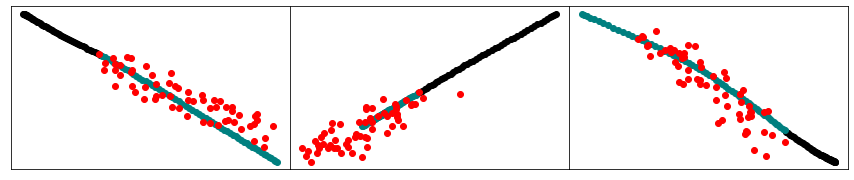

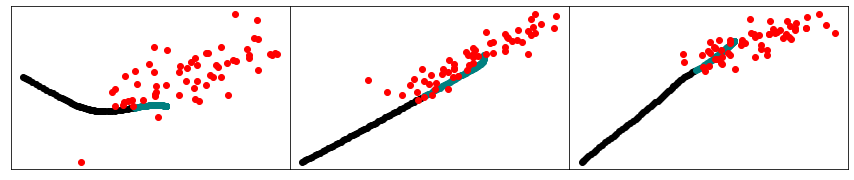

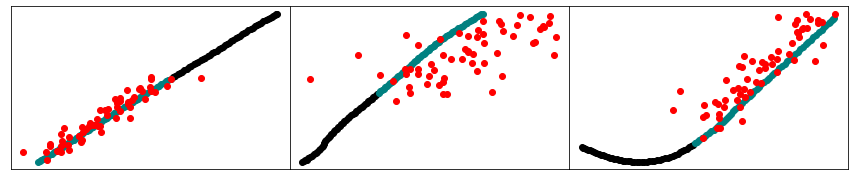

In [96]:
import matplotlib.pyplot as plt
import random

num_samples = 3

val_vis_dataset = ArgoverseDataset(city = 'all', split = 'val')
val_vis_loader = DataLoader(val_dataset,batch_size=3)

def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    inp = inp.to(device)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        inp = inp.to(device)
        pred_traj = pred(inp)
        pred_traj = pred_traj.cpu().detach().numpy()
        inp = inp.cpu()
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1], color='black')
        axs[i].scatter(out[i,:,0], out[i,:,1], color='teal')
        axs[i].scatter(pred_traj[i,:,0], pred_traj[i,:,1], color='red')

        
for i_batch, sample_batch in enumerate(val_vis_loader):
    inp, out = sample_batch
    # print(inp.shape, out.shape)
    
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)

    if (i_batch == (num_samples-1)):
      break

## Calculate Test Predictions and Export to CSV

In [88]:
import pandas as pd

def predictions_to_csv():
    num_pred_steps = 60
    all_preds = np.zeros(shape=(0, num_pred_steps * 2))
    city_col = np.array([])

    print("Calculating Test Trajectory Predictions ...\n")

    print("-----------------------------")

    # Test predictions for ALL cities
    for city_name in cities:

        print("Processing city", city_name)

        # Get Training input values for this city
        test_traj_in, _ = get_city_trajectories(city=city_name, split="test")
        #print(test_traj_in.shape)

        test_pred_arr = []
        # Iterate through all test inputs for this city
        for x in range(len(test_traj_in)):
            # Get the predicted trajectory from the model
            traj_in_tensor = torch.tensor(test_traj_in[x], device=device)
            traj = pred(traj_in_tensor)[0]
            # Add the prediction to the test prediction array
            traj_arr = traj.cpu().detach().numpy()
            test_pred_arr.append(traj_arr)
        test_pred_arr = numpy.array(test_pred_arr)
        # print(test_pred_arr.shape)
    
        # Reshape the predictions to the submission format size (120)
        test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_traj_in.shape[0], num_pred_steps * 2))
        print(test_pred_arr_reshaped.shape)

        print("-----------------------------")

        # Add to total predictions / columns
        all_preds = np.r_[all_preds, test_pred_arr_reshaped]
        city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]
    
    # Convert predictions to csv file
    print('\nExporting Predictions ...\n')
    sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
    submission_file_name = 'predictions_submission.csv'
    sub_df.to_csv(submission_file_name, index=None)
    print('---------------------------------------------------------------')
    print('|  Test Predictions Exported to ./' + submission_file_name + "  |")
    print('---------------------------------------------------------------')


In [89]:
predictions_to_csv()

Calculating Test Trajectory Predictions ...

-----------------------------
Processing city austin
(6325, 120)
-----------------------------
Processing city miami
(7971, 120)
-----------------------------
Processing city pittsburgh
(6361, 120)
-----------------------------
Processing city dearborn
(3671, 120)
-----------------------------
Processing city washington-dc
(3829, 120)
-----------------------------
Processing city palo-alto
(1686, 120)
-----------------------------

Exporting Predictions ...

---------------------------------------------------------------
|  Test Predictions Exported to ./predictions_submission.csv  |
---------------------------------------------------------------


## Save the Model

In [97]:
#torch.save(pred, "linear_model.pt")